# ISIC Skin Lesion Analysis Towards Melanoma Detection 
Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Dermoscopy is a skin imaging modality that has demonstrated improvement for diagnosis of skin cancer compared to unaided visual inspection. However, clinicians should receive adequate training for those improvements to be realized. In order to make expertise more widely available, the International Skin Imaging Collaboration (ISIC) has developed the ISIC Archive, an international repository of dermoscopic images, for both the purposes of clinical training, and for supporting technical research toward automated algorithmic analysis by hosting the ISIC Challenges. https://challenge2019.isic-archive.com/

ISIC Live Leaderboards (2019: Lesion Diagnosis) https://challenge2019.isic-archive.com/live-leaderboard.html


0.569 Overall Score

0.825 Validation Score 

In [1]:
model_name = 'inceptionresnetv2'

In [2]:
approach_name = 'preproc_ext_data_thres'

In [3]:
use_external_data = True
use_weighted_loss = False

In [4]:
filename = "{}_{}".format(model_name, approach_name)
filename

'inceptionresnetv2_preproc_ext_data_thres'

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *
from fastai.metrics import error_rate

import pandas as pd
import seaborn as sns

In [7]:
import pretrainedmodels

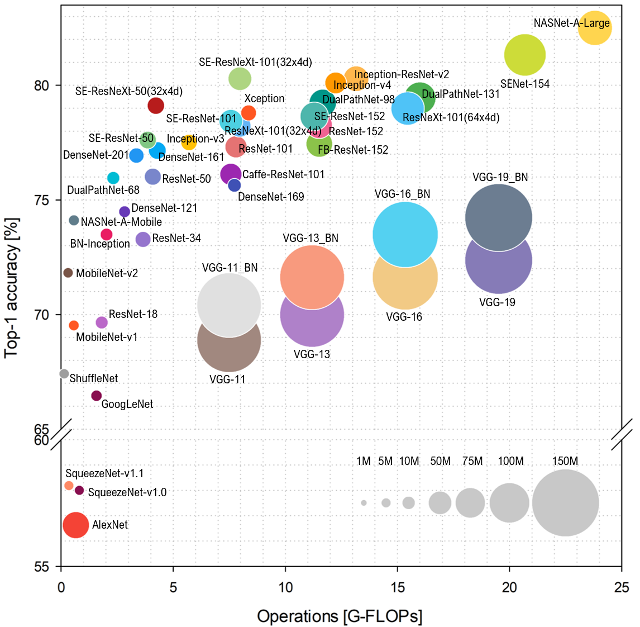
Bianco, S., Cadene, R., Celona, L., and Napoletano, P., Benchmark Analysis of Representative Deep Neural Network Architectures. IEEE Access, 6:64270–64277, 2018, via MLPerf https://arxiv.org/abs/1810.00736

Available pretrained models: https://github.com/Cadene/pretrained-models.pytorch

In [8]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


## Batch size

We have to adjust the batch size to fit within our memory constraints. All input sizes 299x299, except when in parenthesis.

|   | inceptionresnetv2 16 | se_resnext101_32x4d 8 | se_resnext101_32x4d 16  | polynet 8 | polynet 8 (331) |
|---|---|---|---|---|---|
| transfer learning  | 5214MiB | 4306MiB | 7276MiB  | 5854MiB  | 7136MiB |
| model finetuning | 6140MiB | 4988MiB | 7865MiB | 7042MiB  | x |

In [9]:
batch_size = 16

## ISIC Dataset

ISIC 2019 data is provided courtesy of the following sources:
BCN_20000 Dataset: (c) Department of Dermatology, Hospital Clínic de Barcelona
HAM10000 Dataset: (c) by ViDIR Group, Department of Dermatology, Medical University of Vienna; https://doi.org/10.1038/sdata.2018.161
MSK Dataset: (c) Anonymous; https://arxiv.org/abs/1710.05006 ; https://arxiv.org/abs/1902.03368

25,331 images are available for training across 8 different categories:

1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
9. None of the others

Abbreviations used in the dataset
* MEL: Melanoma — a malignant neoplasm derived from melanocytes
* NV: Melanocytic nevi — benign neoplasms of melanocytes
* BCC: Basal cell carcinoma — a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated (bccs do not necessarily produce pigmented lesions)
* AK: Actinic Keratoses and intraepithelial Carcinoma — common non-invasive, variants of squamous cell carcinoma that can be treated locally without surgery
* BKL: Benign keratosis — a generic class that includes seborrheic keratoses, solar lentigo and lichen-planus like keratoses
* DF: Dermatofibroma — a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma
* VASC: Vascular skin lesions ranging from cherry angiomas to angiokeratomas and pyogenic granulomas
* SCC: Squamous cell carcinoma — a common form of skin cancer that develops in the squamous cells that make up the middle and outer layers of the skin
* UNK: None of the others

### Preprocessing
Trim black borders occuring in several images in the ISIC training and test datasets. We use a very small fuzz factor to remove contigous black borders while retaining important parts of the image. Execute only once. This will take some time. Moved preprocessed images to directory isic_preproc.

<pre>
cd ISIC_2019_Training_Input
mogrify -fuzz 5% -bordercolor black -trim +repage -shave 7x7 -format jpg *.jpg
cd ../ISIC_2019_Test_Input
mogrify -fuzz 5% -bordercolor black -trim +repage -shave 7x7 -format jpg *.jpg
</pre>

### Training data

In [10]:
isic_path = 'isic_preproc/ISIC_2019_Training_Input'

In [11]:
def get_isic_df():
    df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
    path_img = 'ISIC_2019_Training_Input'
    
    for label in df.columns[1:]:
        df.loc[df[label] == 1.0, 'label'] = label
        
    df.rename(columns={'image': 'name'}, inplace=True)
    df['name'] = df['name'].apply(lambda x: "{}/{}.jpg".format(isic_path,x))
    df = df[['name', 'label']]
    return df

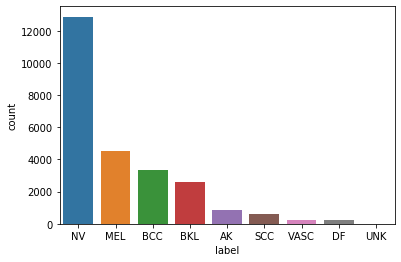

In [12]:
ax = sns.countplot(x="label", data=get_isic_df(), order=['NV', 'MEL', 'BCC', 'BKL', 'AK', 'SCC', 'VASC', 'DF','UNK'])

### Test data

In [13]:
isic_test_path = 'isic_preproc/ISIC_2019_Test_Input'

In [14]:
def get_isic_test_df():
    df = pd.read_csv('ISIC_2019_Test_Metadata.csv', usecols=['image'])
    path_test_img = 'ISIC_2019_Test_Input'
    df.rename(columns={'image': 'name'}, inplace=True)
    return df

In [15]:
get_isic_test_df()

,name
0,ISIC_0034321
1,ISIC_0034322
2,ISIC_0034323
3,ISIC_0034324
4,ISIC_0034325
...,...
8233,ISIC_0073236
8234,ISIC_0073243
8235,ISIC_0073250
8236,ISIC_0073252


## SD-198 Dataset
Sun, X., Yang, J., Sun, M. and Wang, K., 2016, October. A benchmark for automatic visual classification of clinical skin disease images. In European Conference on Computer Vision (pp. 206-222). Springer, Cham.

The dataset contains 6,584 images from 198 classes, varying according to scale, color, shape and structure.

There are some artifacts in the dataset, like sd-198/images/Steroid_Use_abusemisuse_Dermatitis/2015qiangpzb.exe, so we only look for files with the .jpg extension. The database contains macroscopic images, so we are only using it to train for the unknown class.

In [16]:
sd198_path = 'sd-198/'

In [17]:
sd198_isic_classes = {'Actinic_solar_Damage(Actinic_Keratosis)' : 'AK',
                       'Basal_Cell_Carcinoma' : 'BCC',
                       'Dermatofibroma' : 'DF',
                       "Becker's_Nevus" : 'NV',
                       'Blue_Nevus' : 'NV',
                       'Congenital_Nevus' : 'NV',
                       'Benign_Keratosis' : 'BKL', 
                       'Seborrheic_Keratosis' : 'BKL', 
                       'Solar_Lentigo' : 'BKL', 
                       'Lichen_Planus' : 'BKL',
                       'Malignant_Melanoma' : 'MEL', 
                       'Metastatic_Carcinoma' : 'MEL',
                       'Lentigo_Maligna_Melanoma' : 'MEL'}

In [18]:
def get_sd198_df():
    sd198_classes = !ls {sd198_path}/images
    sd198_df = pd.DataFrame()
    for c in sd198_classes:
        images = !find "{sd198_path}images/{c}" -type f -name "*.jpg"
        df = pd.DataFrame()
        df['name'] = images
        
        if c not in sd198_isic_classes.keys():
            df['label'] = 'UNK'
            sd198_df = pd.concat([sd198_df, df])
        #else:
        #    df['label'] = sd198_isic_classes[c]   
        
    return sd198_df

In [19]:
get_sd198_df()

,name,label
0,sd-198/images/Acne_Keloidalis_Nuchae/010069HB.jpg,UNK
1,sd-198/images/Acne_Keloidalis_Nuchae/042338HB.jpg,UNK
2,sd-198/images/Acne_Keloidalis_Nuchae/010018HB.jpg,UNK
3,sd-198/images/Acne_Keloidalis_Nuchae/009931HB.jpg,UNK
4,sd-198/images/Acne_Keloidalis_Nuchae/009995HB.jpg,UNK
...,...,...
33,sd-198/images/Xerosis/030046VB.jpg,UNK
34,sd-198/images/Xerosis/030034VB.jpg,UNK
35,sd-198/images/Xerosis/030053VB.jpg,UNK
36,sd-198/images/Xerosis/030100HB.jpg,UNK


# MED-NODE Dataset

I. Giotis, N. Molders, S. Land, M. Biehl, M.F. Jonkman and N. Petkov: "MED-NODE: A computer-assisted melanoma diagnosis system using non-dermoscopic images", Expert Systems with Applications, 42 (2015), 6578-6585 
http://www.cs.rug.nl/~imaging/databases/melanoma_naevi/

In [20]:
mednode_path = 'complete_mednode_dataset'

In [21]:
def get_mednode_df():
    mel = !find {mednode_path}/melanoma -type f -name '*jpg'
    nv = !find {mednode_path}/naevus -type f -name '*jpg'
    mel_df = pd.DataFrame(mel, columns =['image'])
    nv_df = pd.DataFrame(nv, columns =['image'])
    mel_df['label'] = 'MEL'
    nv_df['label'] = 'NV'
    df = pd.concat([mel_df, nv_df])
    df.rename(columns={'image': 'name'}, inplace=True)    
    return df

In [22]:
get_mednode_df()

,name,label
0,complete_mednode_dataset/melanoma/2190031.jpg,MEL
1,complete_mednode_dataset/melanoma/136733.jpg,MEL
2,complete_mednode_dataset/melanoma/555361-h.jpg,MEL
3,complete_mednode_dataset/melanoma/252641.jpg,MEL
4,complete_mednode_dataset/melanoma/236042-h.jpg,MEL
...,...,...
95,complete_mednode_dataset/naevus/2192103.jpg,NV
96,complete_mednode_dataset/naevus/2159198.jpg,NV
97,complete_mednode_dataset/naevus/2191631.jpg,NV
98,complete_mednode_dataset/naevus/2203331-h.jpg,NV


## 7-point criteria evaluation Database
J. Kawahara, S. Daneshvar, G. Argenziano and G. Hamarneh, "Seven-Point Checklist and Skin Lesion Classification Using Multitask Multimodal Neural Nets," in IEEE Journal of Biomedical and Health Informatics, vol. 23, no. 2, pp. 538-546, March 2019. https://ieeexplore.ieee.org/document/8333693

Downloaded from https://derm.cs.sfu.ca/Welcome.html

In [23]:
derm7pt_path = 'release_v0/'

In [24]:
def get_derm7pt_df():
    df = pd.read_csv(derm7pt_path + 'meta/meta.csv', usecols=['derm', 'diagnosis'])
    df.rename(columns={'derm': 'name', 'diagnosis': 'label'}, inplace=True)
    
    df.loc[df['label'] == 'basal cell carcinoma', 'label'] = 'BCC'
    df.loc[df['label'] == 'lentigo', 'label'] = 'BKL'
    df.loc[df['label'] == 'seborrheic keratosis', 'label'] = 'BKL'
    df.loc[df['label'] == 'dermatofibroma', 'label'] = 'DF'
    df.loc[df['label'] == 'vascular lesion', 'label'] = 'VASC'
    # https://meshb.nlm.nih.gov/record/ui?ui=D008548
    df.loc[df['label'] == 'melanosis', 'label'] = 'BKL'
    # classified as benign melanocytic lesion
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4866625/
    df.loc[df['label'] == 'reed or spitz nevus', 'label'] = 'NV'
    # Melanocytic nevus
    df.loc[df['label'] == 'blue nevus', 'label'] = 'NV'
    df.loc[df['label'] == 'clark nevus', 'label'] = 'NV'
    df.loc[df['label'] == 'combined nevus', 'label'] = 'NV'
    df.loc[df['label'] == 'congenital nevus', 'label'] = 'NV'
    df.loc[df['label'] == 'dermal nevus', 'label'] = 'NV'
    df.loc[df['label'] == 'melanoma', 'label'] = 'MEL'
    df.loc[df['label'] == 'melanoma metastasis', 'label'] = 'MEL'
    df.loc[df['label'] == 'melanoma (in situ)', 'label'] = 'MEL'
    df.loc[df['label'] == 'melanoma (less than 0.76 mm)', 'label'] = 'MEL'
    df.loc[df['label'] == 'melanoma (0.76 to 1.5 mm)', 'label'] = 'MEL'
    df.loc[df['label'] == 'melanoma (more than 1.5 mm)', 'label'] = 'MEL'
    # none of the others
    df.loc[df['label'] == 'miscellaneous', 'label'] = 'UNK'
    df.loc[df['label'] == 'recurrent nevus', 'label'] = 'UNK'
    
    df = df[['name', 'label']]
    df['name'] = df['name'].apply(lambda x: "{}images/{}".format(derm7pt_path,x))
    return df

In [25]:
get_derm7pt_df()

,name,label
0,release_v0/images/NEL/Nel026.jpg,BCC
1,release_v0/images/NEL/Nel028.jpg,BCC
2,release_v0/images/NEL/Nel033.jpg,BCC
3,release_v0/images/NEL/Nel035.jpg,BCC
4,release_v0/images/NEL/Nel037.jpg,BCC
...,...,...
1006,release_v0/images/Fhl/Fhl058.jpg,VASC
1007,release_v0/images/Fhl/Fhl060.jpg,VASC
1008,release_v0/images/Fil/Fil082.jpg,VASC
1009,release_v0/images/New/newl016.jpg,VASC


## PH2 Dataset
Teresa Mendonça, Pedro M. Ferreira, Jorge Marques, Andre R. S. Marcal, Jorge Rozeira. PH² - A dermoscopic image database for research and benchmarking, 35th International Conference of the IEEE Engineering in Medicine and Biology Society, July 3-7, 2013, Osaka, Japan.

https://www.fc.up.pt/addi/ph2%20database.html

C.Barata, M.Ruela, et al., Two Systems for the Detection of Melanomas in Dermoscopy Images using Texture and Color Features, IEEE Systems Journal, no. 99, pp. 1-15, 2013.

Benchmarking results of the classification algorithms applied to the PH² database.
<pre>
      Extracted features            Sensibility/Specificity
Global Method   Color features      90% / 89%
                Texture features    93% / 78%
Local method    Color features      93% / 84%
                Texture features    88% / 76%
</pre>

In [26]:
ph2_path = 'PH2Dataset/'

In [27]:
def get_ph2_df():
    df = pd.read_csv(ph2_path + 'PH2_dataset.txt', sep="\|\|", skipfooter=25, engine='python', usecols=[1,3])
    df.rename(columns={'   Name ': 'name', ' Clinical Diagnosis ': 'label'}, inplace=True)
    # 0: Common Nevus, 1: Atypical Nevus, 2: Melanoma.
    df.loc[df['label'] == 0, 'label'] = 'NV'
    df.loc[df['label'] == 1, 'label'] = 'NV'
    df.loc[df['label'] == 2, 'label'] = 'MEL'
    df['name'] = df['name'].apply(lambda x: "{0}PH2 Dataset images/{1}/{1}_Dermoscopic_Image/{1}.bmp".format(ph2_path,x.strip()))
    return df

In [28]:
get_ph2_df()

,name,label
0,PH2Dataset/PH2 Dataset images/IMD003/IMD003_De...,NV
1,PH2Dataset/PH2 Dataset images/IMD009/IMD009_De...,NV
2,PH2Dataset/PH2 Dataset images/IMD016/IMD016_De...,NV
3,PH2Dataset/PH2 Dataset images/IMD022/IMD022_De...,NV
4,PH2Dataset/PH2 Dataset images/IMD024/IMD024_De...,NV
...,...,...
195,PH2Dataset/PH2 Dataset images/IMD424/IMD424_De...,MEL
196,PH2Dataset/PH2 Dataset images/IMD425/IMD425_De...,MEL
197,PH2Dataset/PH2 Dataset images/IMD426/IMD426_De...,MEL
198,PH2Dataset/PH2 Dataset images/IMD429/IMD429_De...,MEL


## Light Field Image Dataset of Skin Lesions
S. M. M. de Faria et al., "Light Field Image Dataset of Skin Lesions," 2019 41st Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Berlin, Germany, 2019, pp. 3905-3908. DOI: 10.1109/EMBC.2019.8856578

https://www.it.pt/AutomaticPage?id=3459

In [29]:
skinl2_path = 'SKINL2_v2/Dermatoscopic'

In [30]:
!ls {skinl2_path}

'Basal-cell Carcinoma'	 Melanoma   Others
 Hemangioma		 Nevus	   'Seborrheic Keratosis'


In [31]:
def get_skinl2_df():
    bcc = !find "{skinl2_path}/Basal-cell Carcinoma" -type f -name "*.png"
    mel = !find {skinl2_path}/Melanoma -type f -name "*.png"
    bkl = !find "{skinl2_path}/Seborrheic Keratosis" -type f -name "*.png"
    nv = !find {skinl2_path}/Nevus -type f -name "*.png"
    bcc_df = pd.DataFrame(bcc)
    mel_df = pd.DataFrame(mel)
    bkl_df = pd.DataFrame(bkl)
    nv_df = pd.DataFrame(nv)
    bcc_df['label'] = 'BCC'
    mel_df['label'] = 'MEL'
    bkl_df['label'] = 'BKL'
    nv_df['label'] = 'DF'
    df = pd.concat([bcc_df, mel_df, bkl_df, nv_df])
    df.columns = ['name', 'label']
    return df

In [32]:
get_skinl2_df()

,name,label
0,SKINL2_v2/Dermatoscopic/Basal-cell Carcinoma/0...,BCC
1,SKINL2_v2/Dermatoscopic/Basal-cell Carcinoma/0...,BCC
2,SKINL2_v2/Dermatoscopic/Basal-cell Carcinoma/0...,BCC
3,SKINL2_v2/Dermatoscopic/Basal-cell Carcinoma/0...,BCC
4,SKINL2_v2/Dermatoscopic/Basal-cell Carcinoma/0...,BCC
...,...,...
30,SKINL2_v2/Dermatoscopic/Nevus/0030_Dermatoscop...,DF
31,SKINL2_v2/Dermatoscopic/Nevus/0018_2_Dermatosc...,DF
32,SKINL2_v2/Dermatoscopic/Nevus/0038_Dermatoscop...,DF
33,SKINL2_v2/Dermatoscopic/Nevus/0012_Dermatoscop...,DF


# Prepare training dataset

In [33]:
def get_external_df():
    return pd.concat([get_sd198_df(), get_ph2_df(), get_derm7pt_df(), get_skinl2_df(), get_mednode_df()], sort=False)

In [34]:
data_df = pd.concat([get_external_df(), get_isic_df()], sort=False) if use_external_data else get_isic_df()

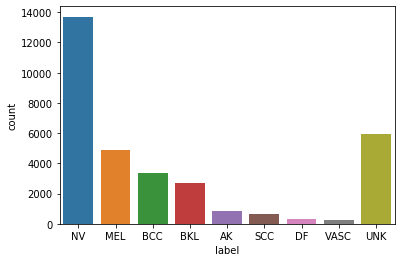

In [35]:
ax = sns.countplot(x="label", data=data_df, order=['NV', 'MEL', 'BCC', 'BKL', 'AK', 'SCC', 'DF', 'VASC', 'UNK'])

In [36]:
data_df

,name,label
0,sd-198/images/Acne_Keloidalis_Nuchae/010069HB.jpg,UNK
1,sd-198/images/Acne_Keloidalis_Nuchae/042338HB.jpg,UNK
2,sd-198/images/Acne_Keloidalis_Nuchae/010018HB.jpg,UNK
3,sd-198/images/Acne_Keloidalis_Nuchae/009931HB.jpg,UNK
4,sd-198/images/Acne_Keloidalis_Nuchae/009995HB.jpg,UNK
...,...,...
25326,isic_preproc/ISIC_2019_Training_Input/ISIC_007...,BCC
25327,isic_preproc/ISIC_2019_Training_Input/ISIC_007...,BKL
25328,isic_preproc/ISIC_2019_Training_Input/ISIC_007...,MEL
25329,isic_preproc/ISIC_2019_Training_Input/ISIC_007...,NV


# Data Augmentation

In [37]:
xtra_tfms = (cutout(n_holes=(1,1), length=(16,16), p=.5))
tfms = get_transforms(max_rotate=45, 
                      p_affine=0.5, 
                      p_lighting=0.5,
                      do_flip=True, 
                      flip_vert=True, 
                      max_zoom=1.05, 
                      max_warp=None, 
                      max_lighting=0.2,
                      xtra_tfms=xtra_tfms)

# Load training and test datasets

In [38]:
data = ImageDataBunch.from_df(path = './', df=data_df, ds_tfms=tfms, size=299,
                              resize_method=ResizeMethod.PAD, bs=batch_size,
                              valid_pct=0.1)

In [39]:
test = ImageList.from_df(df=get_isic_test_df(), path = './', 
                         folder='ISIC_2019_Test_Input', 
                         suffix='.jpg')

In [40]:
data.add_test(test)

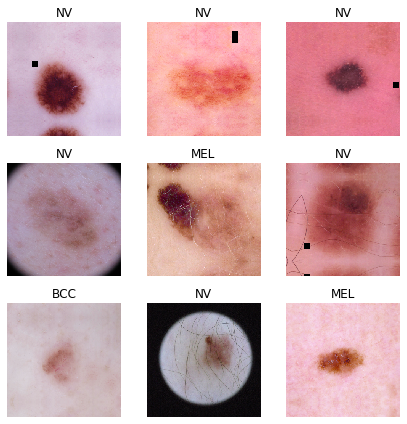

In [41]:
data.show_batch(rows=3, figsize=(6,6))

In [42]:
print(data.classes)
len(data.classes),data.c

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']


(9, 9)

# Load pretrained model

Loading model pretrained on ImageNet dataset.

In [43]:
# cnn_learner() expects a callable function
def get_cadene_model(pretrained=True, model_name=model_name):
    if pretrained:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
    return arch

In [44]:
learn = cnn_learner(data, get_cadene_model, metrics=accuracy)

## Configure weighted cross entropy loss

In [45]:
data_df['label'].value_counts()

NV      13704
UNK      5958
MEL      4904
BCC      3378
BKL      2733
AK        867
SCC       628
DF        294
VASC      282
Name: label, dtype: int64

In [46]:
total_images = data_df.shape[0]
total_images

32748

In [47]:
weights_loss = []

for c in data.classes:
    samples = data_df['label'].value_counts()[c]
    weights_loss.append(1 / (samples / total_images))

In [48]:
data.classes

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

In [49]:
normalized_weights = [x / sum(weights_loss) for x in weights_loss]

In [50]:
normalized_weights

[0.10679773153210781,
 0.0274107854465179,
 0.033879851166607196,
 0.3149443307426445,
 0.018881246582042713,
 0.006756686605249378,
 0.14744209114384949,
 0.01554105962375587,
 0.32834621715722506]

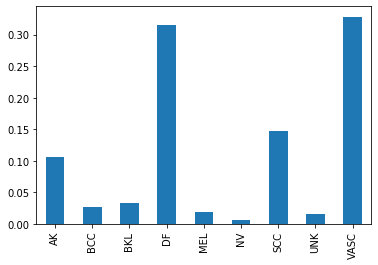

In [51]:
pd.DataFrame(normalized_weights, data.classes).plot(kind='bar', legend=None)

Maybe we should give malignant classes like MEL, BCC higher penalty.

In [52]:
if use_weighted_loss:
    from torch import nn

    class_weights=torch.FloatTensor(normalized_weights).cuda()
    learn.crit = nn.CrossEntropyLoss(weight=class_weights)

# Transfer learning

Fit model using <a href="https://docs.fast.ai/callbacks.one_cycle.html">one cycle</a> policy (https://arxiv.org/pdf/1803.09820.pdf).

In [53]:
learn.fit_one_cycle(64)

epoch,train_loss,valid_loss,accuracy,time
0,1.297096,1.005608,0.672266,12:42
1,1.029903,0.894121,0.683568,12:31
2,0.988607,0.840499,0.700977,12:31
3,0.909461,0.809588,0.709530,12:31
4,0.872328,0.806457,0.722358,12:32
5,0.890186,0.804321,0.720831,12:32
6,0.833338,0.770825,0.728467,12:33
7,0.783868,0.748734,0.742517,12:33
8,0.783843,0.683034,0.760843,12:33
9,0.753634,0.680404,0.759927,12:33


In [54]:
learn.save(filename + '_stage_1')

In [54]:
#learn.load(filename + '_stage_1')

## Results after transfer learning

Look at most incorrect predictions and plot confusion matrix.

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

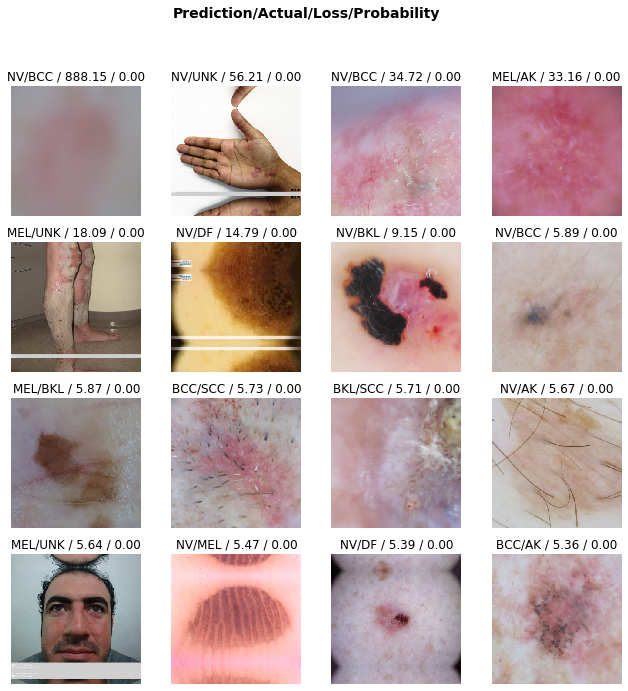

In [56]:
interp.plot_top_losses(16, figsize=(11,11))

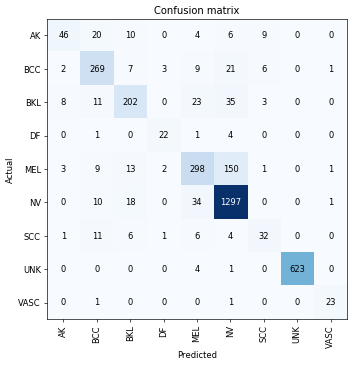

In [57]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

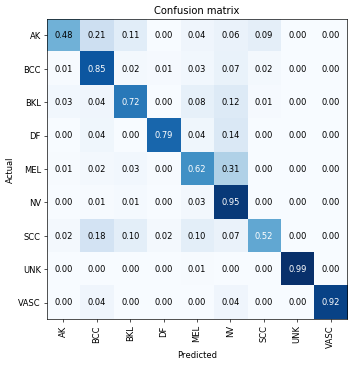

In [58]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)

In [59]:
interp.most_confused(min_val=20)

[('MEL', 'NV', 150),
 ('BKL', 'NV', 35),
 ('NV', 'MEL', 34),
 ('BKL', 'MEL', 23),
 ('BCC', 'NV', 21),
 ('AK', 'BCC', 20)]

# Unfreezing, fine-tuning, differential learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [55]:
learn.unfreeze()

In [61]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


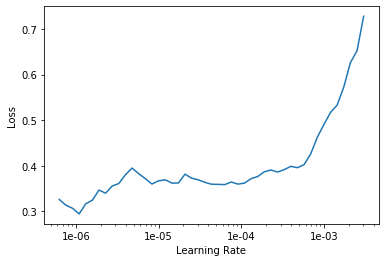

In [62]:
learn.recorder.plot()

In [81]:
learn.fit_one_cycle(3, max_lr=(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.384293,0.507841,0.909285,18:18
1,0.377673,0.366993,0.915394,18:32
2,0.353475,0.289960,0.919670,18:18


In [57]:
learn.save(filename + '_stage_2')

In [82]:
learn.fit_one_cycle(3, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [59]:
learn.save(filename + '_stage_3')

# Evaluate model

In [60]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Show most incorrect predictions. The title of each image shows: prediction, actual, loss, probability of actual class. Grad-CAM heatmaps (http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) are overlaid on each image. 

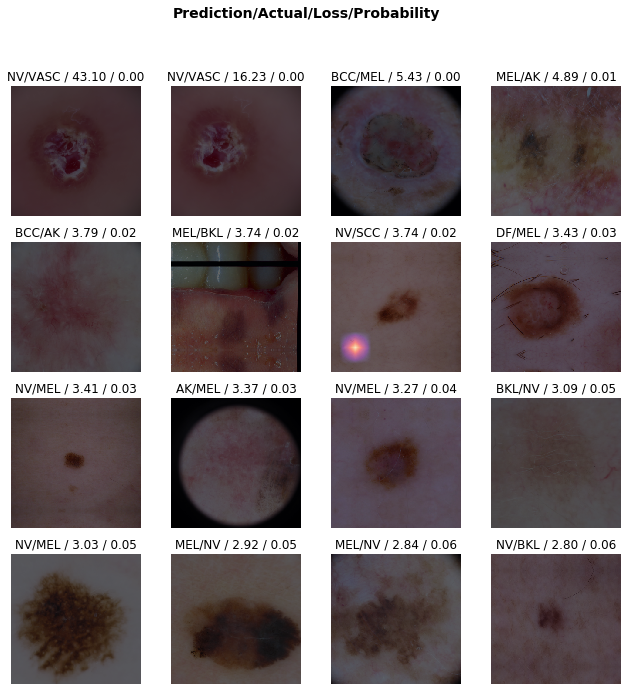

In [61]:
interp.plot_top_losses(16, figsize=(11,11), heatmap=True)

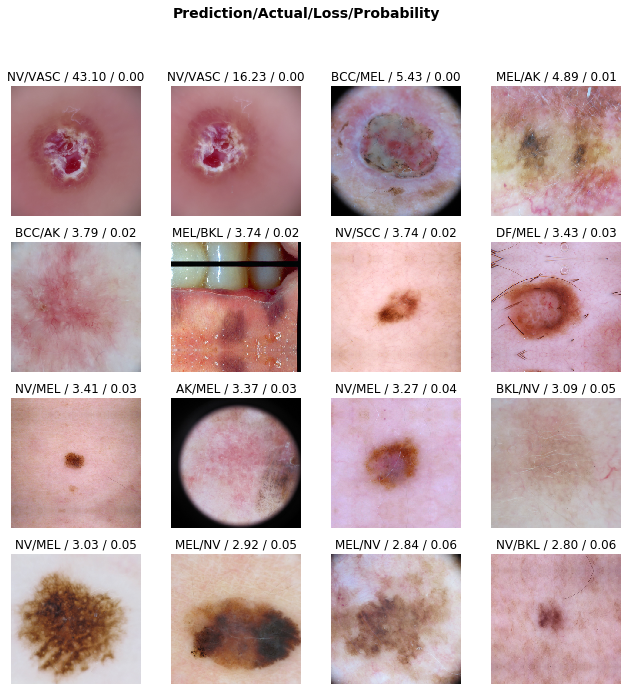

In [62]:
interp.plot_top_losses(16, figsize=(11,11))

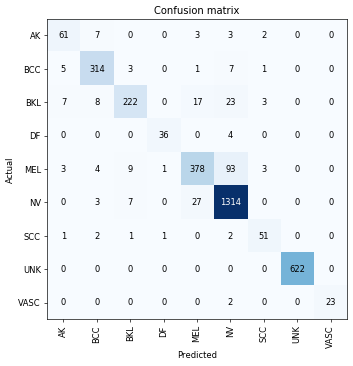

In [63]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

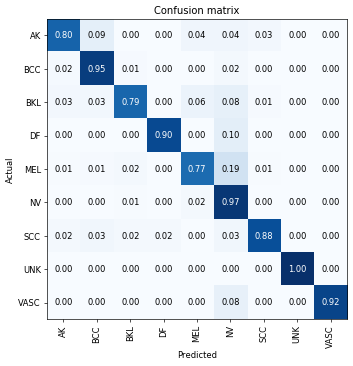

In [64]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)

## Predict on test dataset
Predict on test dataset and prepare CSV containing results.

In [65]:
#learn.load(filename + '_stage_2')

Compute predictions using test time augmentation.

In [66]:
preds, avg_preds, y = learn.TTA(ds_type=DatasetType.Test, beta=None)

In [67]:
result_df = pd.DataFrame(columns=data.classes, data=avg_preds.tolist())

In [68]:
result_df['image'] = get_isic_test_df()

In [69]:
result_df_header = ['image','MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']

We assume no out of distribution images here.

In [70]:
#result_df['UNK'] = 0.0

In [71]:
result_df = result_df[result_df_header]

In [72]:
result_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0034321,0.106757,0.750750,1.240766e-01,5.743832e-04,0.014732,4.919069e-04,1.616414e-03,1.001610e-03,1.377817e-07
1,ISIC_0034322,0.001761,0.997129,6.008370e-06,1.101854e-05,0.000924,1.690298e-04,8.258029e-08,2.985288e-07,5.767603e-08
2,ISIC_0034323,0.010345,0.007027,4.839627e-01,1.634835e-01,0.019080,3.306283e-03,1.412414e-04,3.126472e-01,6.141905e-06
3,ISIC_0034324,0.006253,0.992635,5.099288e-08,2.305522e-07,0.000844,1.997455e-07,2.367205e-04,1.475784e-08,2.953224e-05
4,ISIC_0034325,0.000256,0.999739,1.196878e-09,1.477538e-08,0.000004,3.822581e-08,2.074772e-08,2.411370e-09,6.589237e-11
...,...,...,...,...,...,...,...,...,...,...
8233,ISIC_0073236,0.156828,0.007228,7.885337e-01,8.879947e-03,0.028763,1.371024e-04,8.076552e-05,9.549692e-03,4.107157e-08
8234,ISIC_0073243,0.383813,0.033738,5.768746e-01,1.127628e-03,0.002720,1.089405e-05,1.351562e-03,3.647461e-04,5.364091e-09
8235,ISIC_0073250,0.041573,0.893978,5.051780e-02,3.586315e-03,0.006839,1.056348e-03,2.153531e-03,2.952714e-04,1.176083e-06
8236,ISIC_0073252,0.062908,0.404998,3.760009e-01,7.134914e-03,0.055300,5.663953e-04,9.128833e-02,1.801095e-03,2.008517e-06


### Thresholding

$$
\begin{equation*}p(c|x)= \frac{p(x|c)p(c)}{p(x)}\end{equation*} 
$$

Bayes rule. The model predicts the probability of a class c given x.

 By dividing by $ {p(c) $ we get $ p(x|c) $ .

In [73]:
data.classes

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

In [74]:
weights_loss

[37.77162629757785,
 9.694493783303729,
 11.98243688254665,
 111.38775510204083,
 6.677814029363784,
 2.3896672504378285,
 52.146496815286625,
 5.496475327291037,
 116.12765957446808]

In [75]:
result_thresh_df = result_df.copy()

In [76]:
result_thresh_df.loc[:, data.classes] *= weights_loss

Normalize results.

In [77]:
result_thresh_df.loc[:, data.classes] = result_thresh_df.loc[:, data.classes].div(result_thresh_df.sum(axis=1), axis=0)

In [78]:
# https://stackoverflow.com/a/36328021
def csv_download_link(df, csv_file_name):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))

In [79]:
csv_download_link(result_df, 'result_' + filename + '.csv')
csv_download_link(result_thresh_df, 'result_thresh_' + filename + '.csv')

/home/js/data/isic/result_inceptionresnetv2_preproc_ext_data_thres.csv

/home/js/data/isic/result_thresh_inceptionresnetv2_preproc_ext_data_thres.csv

Submit CSV at https://challenge.isic-archive.com/task/55